In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)

X.shape, y.shape

((442, 10), (442,), (437, 10), (5, 10), (437,), (5,))

In [26]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X.shape, y.shape

((20640, 8), (20640,))

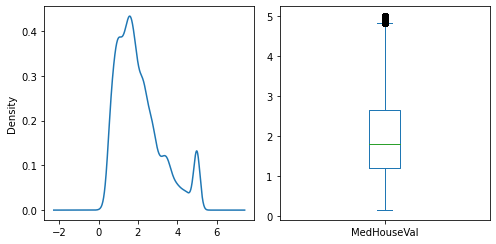

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

y.plot(kind='kde', ax=ax[0])
y.plot(kind='box', ax=ax[1])

plt.tight_layout()

In [44]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class ModelTransformer:
    def __init__(self):
        self.regressors = [
            LinearRegression(),
            Lasso(max_iter=1_000),
            Ridge(max_iter=2_000),
            GradientBoostingRegressor(),
            BayesianRidge(n_iter=1_000)
        ]
        self.r_names = ['lr', 'lasso', 'ridge', 'gbr', 'br']

    def fit(self, X, y=None):
        for m in self.regressors:
            m.fit(X, y)

        return self

    def transform(self, X):
        preds = {f'y_{n}': m.predict(X) 
                 for n, m in zip(self.r_names, self.regressors)}
        
        if isinstance(X, pd.DataFrame):
            for k, v in preds.items():
                X[k] = v
        elif isinstance(X, np.ndarray):
            for k, v in preds.items():
                X = np.hstack([X, v.reshape(-1, 1)])
        
        return X
    
    def __str__(self):
        return 'ModelTransformer()'
    
    def __repr__(self):
        return 'ModelTransformer()'

def get_model():
    model = Pipeline([
        ('imputer', SimpleImputer()),
        ('model_transformers', ModelTransformer()),
        ('scaler', StandardScaler()),
        # ('pca', PCA(n_components=4, random_state=37)),
        ('regressor', RandomForestRegressor())
    ])
    
    return model

def get_baseline_model():
    model = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        # ('pca', PCA(n_components=4, random_state=37)),
        ('regressor', LinearRegression())
    ])
    
    return model

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.99, random_state=37, shuffle=True)

model = get_model()
model.fit(X_tr, y_tr)

mae_tr = mean_absolute_error(y_tr, model.predict(X_tr))
mae_te = mean_absolute_error(y_te, model.predict(X_te))

pd.DataFrame({
    'tr': [mae_tr],
    'te': [mae_te]
})

,tr,te
0,0.11455,0.280144


In [46]:
model = get_baseline_model()
model.fit(X_tr, y_tr)

mae_tr = mean_absolute_error(y_tr, model.predict(X_tr))
mae_te = mean_absolute_error(y_te, model.predict(X_te))

pd.DataFrame({
    'tr': [mae_tr],
    'te': [mae_te]
})

,tr,te
0,0.532514,0.415278


In [48]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from joblib import Parallel, delayed

def get_perf(tr_index, te_index):
    X_tr = X.iloc[tr_index]
    X_te = X.iloc[te_index]
    
    y_tr = y.iloc[tr_index]
    y_te = y.iloc[te_index]
    
    model = get_model()
    model.fit(X_tr, y_tr)
    
    mae_tr = mean_absolute_error(y_tr, model.predict(X_tr))
    mae_te = mean_absolute_error(y_te, model.predict(X_te))
    
    return {'tr': mae_tr, 'te': mae_te}

splitter = LeaveOneOut()
splitter = KFold(n_splits=10, shuffle=True, random_state=37)


r_df = Parallel(n_jobs=-1, prefer='processes')(delayed(get_perf)(tr, te) for tr, te in splitter.split(X, y))
r_df = pd.DataFrame(r_df)
r_df

,tr,te
0,0.115608,0.311392
1,0.115397,0.306993
2,0.115280,0.320036
3,0.115556,0.310409
4,0.114781,0.336587
5,0.115120,0.323142
6,0.115271,0.314635
7,0.114197,0.343040
8,0.115838,0.317661
9,0.115862,0.317536


In [49]:
r_df.mean()

tr    0.115291
te    0.320143
dtype: float64